In [1]:
import copy
import time
import itertools
from collections import defaultdict
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.distributions.categorical import Categorical
from torch.distributions.categorical import Categorical

torch.autograd.set_detect_anomaly(True)

In [2]:
HORIZON = 8
NDIM = 4
BUFSIZE = 16
NHID = 256
N_LAYERS = 2
N_TRAIN_STEPS = 10000
MOMENTUM = 0.9
# Train to sample ratio
TTSR = 1
STTR = 1

In [3]:
tf = lambda x: torch.FloatTensor(x)
tl = lambda x: torch.LongTensor(x)

In [4]:
def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    """makes an MLP with no top layer activation"""
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))


def func_corners(x):
    ax = abs(x)
    return (ax > 0.5).prod(-1) * 0.5 + ((ax < 0.8) * (ax > 0.6)).prod(-1) * 2 + 1e-1

In [5]:
def compute_empirical_distribution_error(env, visited):
    if not len(visited):
        return 1, 100
    hist = defaultdict(int)
    for i in visited:
        hist[i] += 1
    td, end_states, true_r = env.true_density()
    true_density = tf(td)
    Z = sum([hist[i] for i in end_states])
    estimated_density = tf([hist[i] / Z for i in end_states])
    k1 = abs(estimated_density - true_density).mean().item()
    # KL divergence
    kl = (true_density * torch.log(estimated_density / true_density)).sum().item()
    return k1, kl

In [6]:
class GridEnv:

    def __init__(
        self,
        horizon: int,
        ndim: int,
        xrange: list[int],
        allow_backward: bool,
    ):
        self.horizon = horizon
        self.ndim = ndim
        self.start = torch.zeros(self.ndim)
        self.width = xrange[1] - xrange[0]
        self.func = func_corners
        self.xspace = np.linspace(*xrange, horizon)
        self.allow_backward = allow_backward
        self._true_density = None

    def obs(self, state=None):
        state = np.int32(self._state if state is None else state)
        z = np.zeros((self.horizon * self.ndim), dtype=np.float32)
        z[np.arange(len(state)) * self.horizon + state] = 1
        return z

    def s2x(self, state):
        return (self.obs(state).reshape((self.ndim, self.horizon)) * self.xspace[None, :]).sum(1)

    def reset(self):
        self._state = np.int32([0] * self.ndim)
        self._step = 0
        return self.obs(), self.func(self.s2x(self._state)), self._state

    def transition(
        self,
        state,
        action,
        forward=True
    ):
        state = copy.deepcopy(state)
        if forward:
            state[action] += 1
        else: # Transitions backwards
            state[action] -= 1
        return state

    # def parent_transitions(self, state, used_stop_action):
    #     if used_stop_action:
    #         return [self.obs(state), self.ndim]
    #     parent_states = []
    #     parent_actions = []

    #     for i in range(len(state)):
    #         if state[i]>0:
                
    #             parent_states.append(
    #                 self.transition(
    #                     copy.deepcopy(state),
    #                     i,
    #                     forward=False,
    #                 )
    #             )
    #             parent_actions.append(torch.tensor(i))
        
    #     return parent_states, parent_actions

    def parent_transitions(self, s, used_stop_action):
        if used_stop_action:
            return [self.obs(s)], [self.ndim]
        parents = []
        actions = []
        for i in range(self.ndim):
            if s[i] > 0:
                sp = s + 0
                sp[i] -= 1
                if sp.max() == self.horizon-1: # can't have a terminal parent
                    continue
                parents += [self.obs(sp)]
                actions += [i]
        return parents, actions

    def step(self, a, s=None):
        if self.allow_backward:
            return self.step_chain(a, s)
        return self.step_dag(a, s)
    
    def step_dag(self, a, s=None):
        _s = s
        s = (self._state if s is None else s) + 0
        if a < self.ndim:
            s[a] += 1

        done = s.max() >= self.horizon - 1 or a == self.ndim
        if _s is None:
            self._state = s
            self._step += 1
        return self.obs(s), 0 if not done else self.func(self.s2x(s)), done, s

    def step_chain(self, a, s=None):
        _s = s
        s = (self._state if s is None else s) + 0
        sc = s + 0
        if a < self.ndim:
            s[a] = min(s[a]+1, self.horizon-1)
        if a >= self.ndim:
            s[a-self.ndim] = max(s[a-self.ndim]-1,0)

        reverse_a = ((a + self.ndim) % (2 * self.ndim)) if any(sc != s) else a

        if _s is None:
            self._state = s
            self._step += 1
        return self.obs(s), self.func(self.s2x(s)), s, reverse_a

    def true_density(self):
        if self._true_density is not None:
            return self._true_density
        all_int_states = np.int32(list(itertools.product(*[list(range(self.horizon))]*self.ndim)))
        state_mask = np.array([len(self.parent_transitions(s, False)[0]) > 0 or sum(s) == 0
                               for s in all_int_states])
        all_xs = (np.float32(all_int_states) / (self.horizon-1) *
                  (self.xspace[-1] - self.xspace[0]) + self.xspace[0])
        traj_rewards = self.func(all_xs)[state_mask]
        self._true_density = (traj_rewards / traj_rewards.sum(),
                              list(map(tuple,all_int_states[state_mask])),
                              traj_rewards)
        return self._true_density

In [7]:
class ReplayBuffer:

    def __init__(self, args, env):
        self.buf = []
        self.strat = args.replay_strategy
        self.sample_size = args.replay_sample_size
        self.bufsize = args.replay_buf_size
        self.env = env

    def add(self, x, r_x):
        if self.strat == 'top_k':
            if len(self.buf) < self.bufsize or r_x > self.buf[0][0]:
                self.buf = sorted(self.buf + [(r_x, x)])[-self.bufsize:]

    def sample(self):
        if not len(self.buf):
            return []
        idxs = np.random.randint(0, len(self.buf), self.sample_size)
        return sum([self.generate_backward(*self.buf[i]) for i in idxs], [])
    
    def generate_backward(self, r, s0):
        s = np.int8(s0)
        os0 = self.env.obs(s)
        # If s0 is a forced-terminal state, the the action that leads
        # to it is s0.argmax() which .parents finds, but if it isn't,
        # we must indicate that the agent ended the trajectory with
        # the stop action
        used_stop_action = s.max() < self.env.horizon - 1
        done = True
        # Now we work backward from that last transition
        traj = []
        while s.sum() > 0:
            parents, actions = self.env.parent_transitions(s, used_stop_action)
            # add the transition
            traj.append([tf(i) for i in (parents, actions, [r], [self.env.obs(s)], [done])])
            # Then randomly choose a parent state
            if not used_stop_action:
                i = np.random.randint(0, len(parents))
                a = actions[i]
                s[a] -= 1
            # Values for intermediary trajectory states:
            used_stop_action = False
            done = False
            r = 0
        return traj


In [8]:
class FlowNetAgent:

    def __init__(self, args, envs):
        self.model = self.model = make_mlp(
            [args.horizon * args.ndim] +
            [args.n_hid] * args.n_layers +
            [args.ndim+1]
        )
        self.target = copy.deepcopy(self.model)
        self.envs = envs
        self.ndim = args.ndim
        self.tau = args.bootstrap_tau
        self.replay = ReplayBuffer(args, envs[0])
    
    def parameters(self):
        return self.model.parameters()

    def sample_many(self, mbsize, all_visited):
        batch = []
        batch += self.replay.sample()
        s = tf([i.reset()[0] for i in self.envs])
        done = [False] * mbsize
        while not all(done):
            # Note to self: this is ugly, ugly code
            with torch.no_grad():
                acts = Categorical(logits=self.model(s)).sample()
            step = [i.step(a) for i,a in zip([e for d, e in zip(done, self.envs) if not d], acts)]
            p_a = [self.envs[0].parent_transitions(sp_state, a == self.ndim)
                   for a, (sp, r, done, sp_state) in zip(acts, step)]
            batch += [[tf(i) for i in (p, a, [r], [sp], [d])]
                      for (p, a), (sp, r, d, _) in zip(p_a, step)]
            c = itertools.count(0)
            m = {j:next(c) for j in range(mbsize) if not done[j]}
            done = [bool(d or step[m[i]][2]) for i, d in enumerate(done)]
            s = tf([i[0] for i in step if not i[2]])
            for (_, r, d, sp) in step:
                if d:
                    all_visited.append(tuple(sp))
                    self.replay.add(tuple(sp), r)
        return batch
    
    def learn_from(self, it, batch):
        loginf = tf([1000])
        batch_idxs = tl(sum([[i]*len(parents) for i, (parents,_,_,_,_) in enumerate(batch)], []))
        parents, actions, r, sp, done = map(torch.cat, zip(*batch))
        parents_Qsa = self.model(parents)[torch.arange(parents.shape[0]), actions.long()]
        in_flow = torch.log(torch.zeros((sp.shape[0],))
                            .index_add_(0, batch_idxs, torch.exp(parents_Qsa)))
        if self.tau > 0:
            with torch.no_grad(): next_q = self.target(sp)
        else:
            next_q = self.model(sp)
        next_qd = next_q * (1-done).unsqueeze(1) + done.unsqueeze(1) * (-loginf)
        out_flow = torch.logsumexp(torch.cat([torch.log(r)[:, None], next_qd], 1), 1)
        loss = (in_flow - out_flow).pow(2).mean()

        with torch.no_grad():
            term_loss = ((in_flow - out_flow) * done).pow(2).sum() / (done.sum() + 1e-20)
            flow_loss = ((in_flow - out_flow) * (1-done)).pow(2).sum() / ((1-done).sum() + 1e-20)

        if self.tau > 0:
            for a,b in zip(self.model.parameters(), self.target.parameters()):
                b.data.mul_(1-self.tau).add_(self.tau*a)

        return loss, term_loss, flow_loss

In [9]:
class MHAgent:
    def __init__(self, args, envs):
        self.envs = envs
        self.batch = [i.reset() for i in envs] # The N MCMC chains
        self.bufsize = args.bufsize
        self.nactions = args.ndim*2
        self.model = None

    def parameters(self):
        return []

    def sample_many(self, mbsize, all_visited):
        r = np.float32([i[1] for i in self.batch])
        a = np.random.randint(0, self.nactions, self.bufsize)
        steps = [self.envs[j].step(a[j], s=self.batch[j][2]) for j in range(self.bufsize)]
        rp = np.float32([i[1] for i in steps])
        A = rp / r
        U = np.random.uniform(0,1,self.bufsize)
        for j in range(self.bufsize):
            if A[j] > U[j]: # Accept
                self.batch[j] = (None, rp[j], steps[j][2])
                all_visited.append(tuple(steps[j][2]))
        return []

    def learn_from(self, *a):
        return None

In [10]:
class PPOAgent:
    def __init__(self, args, envs):
        self.model = make_mlp([args.horizon * args.ndim] +
                              [args.n_hid] * args.n_layers +
                              [args.ndim+1+1]) # +1 for stop action, +1 for V
        self.envs = envs
        self.mbsize = args.mbsize
        self.clip_param = args.ppo_clip
        self.entropy_coef = args.ppo_entropy_coef

    def parameters(self):
        return self.model.parameters()

    def sample_many(self, mbsize, all_visited):
        batch = []
        s = tf([i.reset()[0] for i in self.envs])
        done = [False] * mbsize
        trajs = defaultdict(list)
        while not all(done):
            # Note to self: this is ugly, ugly code as well
            with torch.no_grad():
                pol = Categorical(logits=self.model(s)[:, :-1])
                acts = pol.sample()
            step = [i.step(a) for i,a in zip([e for d, e in zip(done, self.envs) if not d], acts)]
            log_probs = pol.log_prob(acts)
            c = itertools.count(0)
            m = {j:next(c) for j in range(mbsize) if not done[j]}
            for si, a, (sp, r, d, _), (traj_idx, _), lp in zip(s, acts, step, sorted(m.items()), log_probs):
                trajs[traj_idx].append([si[None,:]] + [tf([i]) for i in (a, r, sp, d, lp)])
            done = [bool(d or step[m[i]][2]) for i, d in enumerate(done)]
            s = tf([i[0] for i in step if not i[2]])
            for (_, r, d, sp) in step:
                if d:
                    all_visited.append(tuple(sp))
        # Compute advantages
        for tau in trajs.values():
            s, a, r, sp, d, lp = [torch.cat(i, 0) for i in zip(*tau)]
            with torch.no_grad():
                vs = self.model(s)[:, -1]
                vsp = self.model(sp)[:, -1]
            adv = r + vsp * (1-d) - vs
            for i, A in zip(tau, adv):
                i.append(r[-1].unsqueeze(0)) # The return is always just the last reward, gamma is 1
                i.append(A.unsqueeze(0))
        return sum(trajs.values(), [])

    def learn_from(self, it, batch):
        idxs = np.random.randint(0, len(batch), self.mbsize)
        s, a, r, sp, d, lp, G, A = [torch.cat(i, 0) for i in zip(*[batch[i] for i in idxs])]
        o = self.model(s)
        logits, values = o[:, :-1], o[:, -1]

        new_pol = Categorical(logits=logits)
        new_logprob = new_pol.log_prob(a)
        ratio = torch.exp(new_logprob - lp)

        surr1 = ratio * A
        surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                            1.0 + self.clip_param) * A
        action_loss = -torch.min(surr1, surr2).mean()
        value_loss = 0.5 * (G - values).pow(2).mean()
        entropy = new_pol.entropy().mean()
        return (action_loss + value_loss - entropy * self.entropy_coef,
                action_loss, value_loss, entropy)

In [11]:
@dataclass
class FlowNetAgentArgs:

    horizon: int
    ndim: int
    # xrange: list[int]
    n_hid: int
    n_layers: int
    bootstrap_tau: float = 0
    replay_strategy: str = 'none'
    replay_sample_size: int = 2
    replay_buf_size: int = 100


@dataclass
class OptArgs:

    learning_rate: float = 1e-4
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999


@dataclass
class GeneralArgs:
    
    n_train_steps: int
    progress: bool = False
    mbsize: int = 16
    clip_grad_norm: int = 0
    num_empirical_loss: int = 10000

@dataclass
class MHAgentArgs:

    bufsize: int
    ndim: int

In [12]:
flownet_args = FlowNetAgentArgs(
    horizon=HORIZON,
    ndim=NDIM,
    # xrange=[-1, 1],
    n_hid=NHID,
    n_layers=N_LAYERS,
)

opt_args = OptArgs()

general_args = GeneralArgs(
    n_train_steps=N_TRAIN_STEPS,
    progress=True,
)

## Flow Network

In [13]:
env = GridEnv(
    horizon=HORIZON,
    ndim=NDIM,
    xrange=[-1, 1],
    allow_backward=False
)

envs = [
    GridEnv(
        horizon=HORIZON,
        ndim=NDIM,
        xrange=[-1, 1],
        allow_backward=False
    ) for _ in range(BUFSIZE)
]

flownet_agent = FlowNetAgent(
    args=flownet_args, 
    envs=envs,
)

opt = torch.optim.Adam(
    flownet_agent.parameters(),
    opt_args.learning_rate,
    betas=(
        opt_args.adam_beta1,
        opt_args.adam_beta2
    )
)


all_losses_flownet = []
empirical_distrib_losses_flownet = []
all_visited_flownet = []
all_times_flownet = []

start_time = time.time()

for i in tqdm(range(general_args.n_train_steps+1), disable=not general_args.progress):
    data = []
    for j in range(STTR):
        data += flownet_agent.sample_many(general_args.mbsize, all_visited_flownet)
    for j in range(TTSR):
        losses = flownet_agent.learn_from(i * TTSR + j, data) # returns (opt loss, *metrics)
        if losses is not None:
            losses[0].backward()
            if general_args.clip_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(flownet_agent.parameters(),
                                                general_args.clip_grad_norm)
            opt.step()
            opt.zero_grad()
            all_losses_flownet.append([i.item() for i in losses])

    empirical_distrib_losses_flownet.append(
        compute_empirical_distribution_error(
            env,
            all_visited_flownet[-general_args.num_empirical_loss:],
        )[0]
    )

    all_times_flownet.append(time.time() - start_time)

  0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11116\2447535103.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  tf = lambda x: torch.FloatTensor(x)
  0%|          | 1/10001 [00:00<1:13:37,  2.26it/s]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11116\2447535103.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  tf = lambda x: torch.FloatTensor(x)
100%|██████████| 10001/10001 [29:01<00:00,  5.74it/s] 


## Markov Chain Monte Carlo Metropolis Hastings Agent

In [14]:
env = GridEnv(
    horizon=HORIZON,
    ndim=NDIM,
    xrange=[-1, 1],
    allow_backward=True
)

envs = [
    GridEnv(
        horizon=HORIZON,
        ndim=NDIM,
        xrange=[-1, 1],
        allow_backward=True
    ) for _ in range(BUFSIZE)
]

mha_args = MHAgentArgs(
    bufsize=BUFSIZE,
    ndim=NDIM,
)

mha_agent = MHAgent(
    args=mha_args,
    envs=envs
)

In [15]:
all_losses_mha = []
all_visited_mha = []
empirical_distrib_losses_mha = []
all_times_mha = []

start_time = time.time()
for i in tqdm(range(general_args.n_train_steps+1), disable=not general_args.progress):
    for j in range(STTR):
        mha_agent.sample_many(general_args.mbsize, all_visited_mha)
    empirical_distrib_losses_mha.append(
        compute_empirical_distribution_error(
            env,
            all_visited_mha[-general_args.num_empirical_loss:],
        )[0]
    )
    all_times_mha.append(time.time() - start_time)

100%|██████████| 10001/10001 [02:28<00:00, 67.26it/s]


## PPO

In [16]:
@dataclass
class PPOArgs:

    horizon: int
    ndim: int
    n_hid: int
    n_layers: int
    mbsize: int
    ppo_clip: float
    ppo_entropy_coef: float
    ppo_num_epochs: int
    ppo_epoch_size: int
    # clip_grad_norm: float

In [17]:
env = GridEnv(
    horizon=HORIZON,
    ndim=NDIM,
    xrange=[-1, 1],
    allow_backward=False
)

envs = [
    GridEnv(
        horizon=HORIZON,
        ndim=NDIM,
        xrange=[-1, 1],
        allow_backward=False
    ) for _ in range(BUFSIZE)
]

ppo_args = PPOArgs(
    horizon=HORIZON,
    ndim=NDIM,
    n_hid=NHID,
    n_layers=N_LAYERS,
    mbsize=general_args.mbsize,
    ppo_clip=0.02,
    ppo_entropy_coef=1e-1,
    ppo_num_epochs=8,
    ppo_epoch_size=8,
)

ppo_agent = PPOAgent(
    args=ppo_args,
    envs=envs
)

In [22]:
all_losses_ppo = []
empirical_distrib_losses_ppo = []
all_visited_ppo = []
all_times_ppo = []

start_time = time.time()
for i in tqdm(range((general_args.n_train_steps+1)//10), disable=not general_args.progress):
    data = []
    for j in range(ppo_args.ppo_epoch_size):
        data += ppo_agent.sample_many(general_args.mbsize, all_visited_ppo)
    for j in range(ppo_args.ppo_num_epochs):
        losses = ppo_agent.learn_from(i * ppo_args.ppo_num_epochs + j, data) # returns (opt loss, *metrics)
        if losses is not None:
            losses[0].backward()
            if general_args.clip_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(ppo_agent.parameters(),
                                                general_args.clip_grad_norm)
            opt.step()
            opt.zero_grad()
            all_losses_ppo.append([i.item() for i in losses])

    empirical_distrib_losses_ppo.append(
        compute_empirical_distribution_error(
            env,
            all_visited_ppo[-general_args.num_empirical_loss:],
        )[0]
    )
    all_times_ppo.append(time.time() - start_time)

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11116\2447535103.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  tf = lambda x: torch.FloatTensor(x)
100%|██████████| 1000/1000 [14:44<00:00,  1.13it/s]


## Plot

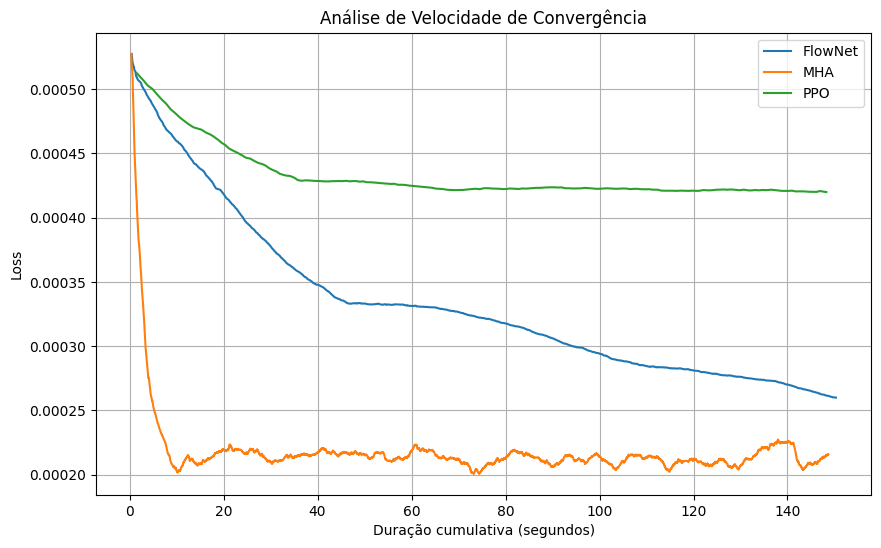

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(
    all_times_flownet[:int(len(all_times_ppo)/1)],
    empirical_distrib_losses_flownet[:int(len(all_times_ppo)/1)],
    label='FlowNet'
)
plt.plot(all_times_mha, empirical_distrib_losses_mha, label='MHA')
plt.plot(
    all_times_ppo[:int(len(all_times_ppo)/5.8)],
    empirical_distrib_losses_ppo[:int(len(all_times_ppo)/5.8)],
    label='PPO',
)
plt.xlabel('Duração cumulativa (segundos)')
plt.ylabel('Loss')
plt.title('Análise de Velocidade de Convergência')
plt.legend()
plt.grid(True)
plt.show()

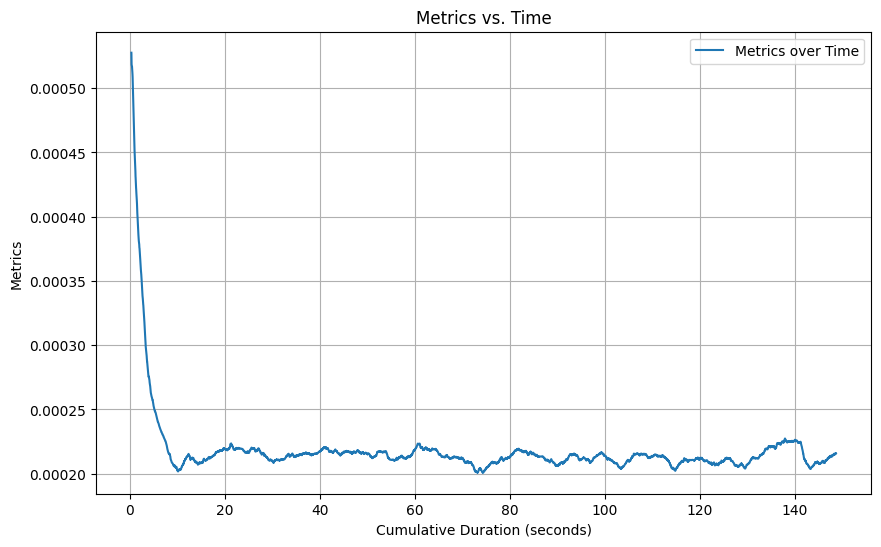

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(all_times_mha, empirical_distrib_losses_mha, label='Metrics over Time')
plt.xlabel('Cumulative Duration (seconds)')
plt.ylabel('Metrics')
plt.title('Metrics vs. Time')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
func_corners(torch.tensor(all_visited_flownet[0]))

tensor(0.1000)

In [59]:
(torch.tensor([func_corners(torch.tensor(x)) for x in set(all_visited_flownet)])>=0.6).sum()

tensor(2160)

In [60]:
np.int8(all_visited_flownet)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [5, 4, 6, 1],
       [6, 6, 1, 7],
       [5, 6, 4, 7]], dtype=int8)

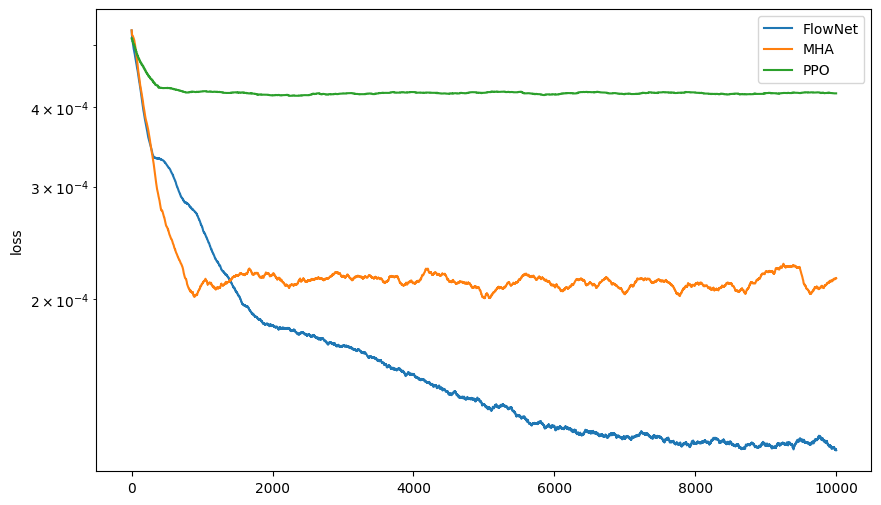

In [46]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
plt.sca(ax)
plt.plot(empirical_distrib_losses_flownet, label="FlowNet")
plt.plot(empirical_distrib_losses_mha, label="MHA")
plt.plot(new_empirical_distrib_losses_ppo, label="PPO")
plt.yscale('log')
plt.ylabel('loss')

# Adding legend
plt.legend()

plt.show()

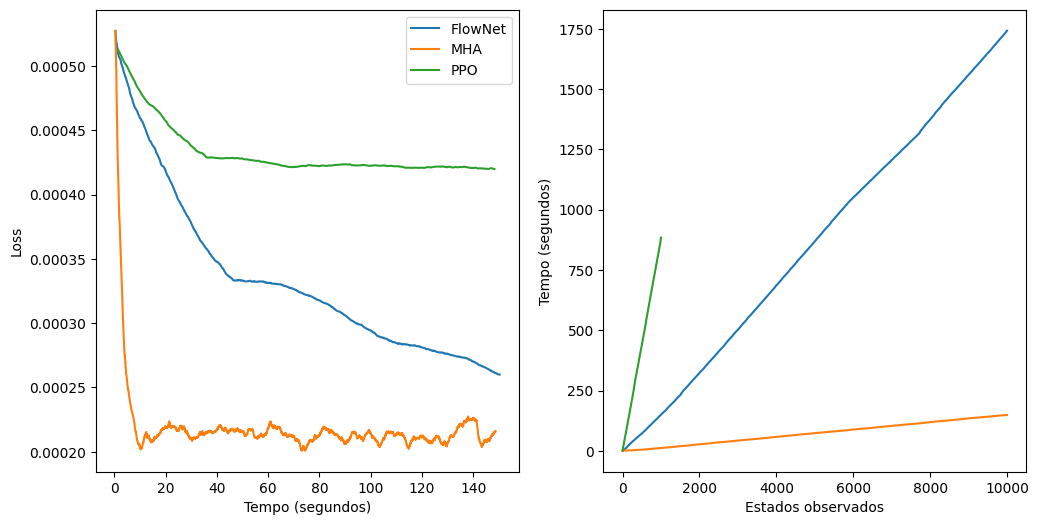

In [71]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
plt.sca(ax[1])
plt.plot(all_times_flownet, label="FlowNet")
plt.plot(all_times_mha, label="MHA")
plt.plot(all_times_ppo, label="PPO")
# plt.yscale('log')
plt.ylabel('Tempo (segundos)')
plt.xlabel('Estados observados')

# f, ax = plt.subplots(1, 1, figsize=(10,6))
plt.sca(ax[0])
plt.plot(
    all_times_flownet[:int(len(all_times_ppo)/1)],
    empirical_distrib_losses_flownet[:int(len(all_times_ppo)/1)],
    label='FlowNet'
)
plt.plot(all_times_mha, empirical_distrib_losses_mha, label='MHA')
plt.plot(
    all_times_ppo[:int(len(all_times_ppo)/5.8)],
    empirical_distrib_losses_ppo[:int(len(all_times_ppo)/5.8)],
    label='PPO',
)
plt.xlabel('Tempo (segundos)')
plt.ylabel('Loss')

# Adding legend
plt.legend()

plt.show()

In [45]:
new_empirical_distrib_losses_ppo = []

for i in range(0, len(empirical_distrib_losses_ppo)):
    new_empirical_distrib_losses_ppo.extend([empirical_distrib_losses_ppo[i]]*10)

In [44]:
[empirical_distrib_losses_ppo[0]]*10

[0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552,
 0.000512405764311552]

In [42]:
empirical_distrib_losses_flownet

[0.0005272412090562284,
 0.0005236639408394694,
 0.0005212438991293311,
 0.0005199812585487962,
 0.0005180874140933156,
 0.0005175613914616406,
 0.0005151414079591632,
 0.0005145100876688957,
 0.0005138787673786283,
 0.0005101962597109377,
 0.0005092492210678756,
 0.0005081971175968647,
 0.0005072268540970981,
 0.0005066724261268973,
 0.0005060935509391129,
 0.0005054951179772615,
 0.000504985626321286,
 0.0005039364914409816,
 0.0005023049307055771,
 0.0005018840893171728,
 0.0005011475295759737,
 0.0005002006073482335,
 0.0004994641058146954,
 0.0004988327855244279,
 0.0004980962839908898,
 0.0004967284621670842,
 0.0004956763004884124,
 0.0004949397407472134,
 0.0004944136599078774,
 0.0004936771583743393,
 0.0004926249966956675,
 0.0004923093947581947,
 0.0004918884951621294,
 0.0004910467541776597,
 0.000490731094032526,
 0.0004895736929029226,
 0.0004890476702712476,
 0.0004886267706751823,
 0.0004879954503849149,
 0.0004871537094004452,
 0.00048641717876307666,
 0.00048599633737